In [1]:
import einops
import torch

from einops.layers.torch import EinMix

from utils.components import *
from utils.config import *
from utils.einmask import EinMask

from utils.masking import *

import itertools

In [2]:
import matplotlib.pyplot as plt

In [3]:
network = NetworkConfig(dim=512, num_latents=32, num_layers=12, num_tails=4, use_checkpoint=False, dim_in=256, dim_coords=64,
                        wavelengths=[(1,8),(1,8),(1,64),(1,128)])

In [4]:
class HeuristicMasking(torch.nn.Module):
    def __init__(self, world: WorldConfig, objective: ObjectiveConfig):
        super().__init__()
        # configs
        self.world = world
        self.objective = objective

        # min/max rates
        self.src_min = objective.c0_src
        self.src_max = objective.c1_src
        self.tgt_min = objective.c0_tgt
        self.tgt_max = objective.c1_tgt

        self.c1_prior = objective.c1_prior

        # attributes
        self.k_min = default(objective.k_min, 1)
        self.k_max = default(objective.k_max, world.num_tokens // world.token_sizes['v'])

        # Events
        assert all([d in world.flat_token_pattern for d in objective.event_dims]), 'event dims not in token pattern'
        self.register_buffer('num_events', torch.tensor([world.token_sizes[d] for d in objective.event_dims]).prod())
        self.event_pattern = f'({" ".join(objective.event_dims)})'

    def forward(self, shape: tuple, rng: torch.Generator = None):
        u = torch.rand((2, *shape, self.num_events), generator = rng, device = self.num_events.device)
        p = torch.where(u[0] > self.c1_prior, u[1].clamp(0.1, 0.9), 1e-16)
        
        p = einops.repeat(p,
            f'... {self.event_pattern} -> ... (t h w)', 
            t = self.world.token_sizes['t'], h = self.world.token_sizes['h'], w = self.world.token_sizes['w']
            )

        rs = torch.rand((2, self.world.token_sizes['v']), generator = rng, device = self.num_events.device)
        r_src = self.src_min + (self.src_max - self.src_min) * rs[0]
        r_tgt = self.tgt_min + (self.tgt_max - self.tgt_min) * rs[1]

        src = torch.cat([torch.multinomial(p, int(r * self.k_max), generator=rng) + i * self.k_max for i, r in enumerate(r_src)], dim = -1)
        tgt = torch.cat([torch.multinomial(1 - p, int(r * self.k_max), generator=rng) + i * self.k_max for i, r in enumerate(r_tgt)], dim = -1)

        return src, tgt, None, None


In [5]:
class MultinomialMasking(torch.nn.Module):
    def __init__(self, world: WorldConfig, objective: ObjectiveConfig):
        super().__init__()
        # configs
        self.world = world
        self.objective = objective

        # Events
        assert all([d in world.flat_token_pattern for d in objective.event_dims]), 'event dims not in token pattern'
        self.num_events = torch.tensor([world.token_sizes[d] for d in objective.event_dims]).prod()
        self.event_pattern = f'({" ".join(objective.event_dims)})'

        #schedule
        self.src_rates = StableKumaraswamy(c0=objective.c0_src, c1=objective.c1_src)
        self.tgt_rates = StableKumaraswamy(c0=objective.c0_tgt, c1=objective.c1_tgt)
        self.prior = StableKumaraswamy(c0= objective.c0_prior, c1= objective.c1_prior, epsilon=1e-2)
        
        # attributes
        self.k_min = default(objective.k_min, 2)
        self.k_max = default(objective.k_max, world.num_tokens)

    def expand_events(self, *args):
        return einops.repeat(
            [*args],
            f'args ... {self.event_pattern} -> args ... {self.world.flat_token_pattern}', 
            **self.world.token_sizes
            )
    
    def k_from_rates(self, r: float):
        return int(self.k_min + (self.k_max - self.k_min) * r)

    def forward(self, shape: tuple, rng: torch.Generator = None):
        # sample prior
        t = torch.rand((*shape, self.num_events), device=self.num_events.device, generator= rng)
        t = t * (1.0 - 2.0 * self.prior.epsilon) + self.prior.epsilon
        psrc, ptgt = self.prior.quantile(t), self.prior.quantile(1 - t)
        psrc, ptgt = self.expand_events(psrc, ptgt)
        
        # sample rates
        r_src, _ = self.src_rates((1,), rng)
        k_src = self.k_from_rates(r_src)
        r_tgt, _ = self.tgt_rates((1,), rng)
        k_tgt = self.k_from_rates(r_tgt)
        # sample indices
        src = torch.multinomial(psrc, k_src, generator=rng)
        tgt = torch.multinomial(ptgt, k_tgt, generator = rng)
        return src, tgt, _, _

In [6]:
class MultinomialMasking(torch.nn.Module):
    def __init__(self, world: WorldConfig, objective: ObjectiveConfig):
        super().__init__()
        # configs
        self.world = world
        self.objective = objective

        # Events
        assert all([d in world.flat_token_pattern for d in objective.event_dims]), 'event dims not in token pattern'
        self.num_events = torch.tensor([world.token_sizes[d] for d in objective.event_dims]).prod()
        self.event_pattern = f'({" ".join(objective.event_dims)})'
        self.event_sizes = {d: world.token_sizes[d] for d in objective.event_dims}

        #schedule
        self.src_rates = StableKumaraswamy(c0=objective.c0_src, c1=objective.c1_src)
        self.tgt_rates = StableKumaraswamy(c0=objective.c0_tgt, c1=objective.c1_tgt)
        self.prior = StableKumaraswamy(c0= objective.c0_prior, c1= objective.c1_prior, epsilon=1e-2)
        
        # attributes
        self.k_min = default(objective.k_min, 2)
        self.k_max = default(objective.k_max, world.num_tokens)

    def expand_events(self, *args):
        return einops.repeat(
            [*args],
            f'args ... {self.event_pattern} -> args ... {self.world.flat_token_pattern}', 
            **self.world.token_sizes
            )
    
    def k_from_rates(self, r: float):
        return int(self.k_min + (self.k_max - self.k_min) * r)

    def _compute_event_weights(self, shape: tuple, rng: torch.Generator = None) -> torch.Tensor:
            """Generates factorized probability weights for source and target masking."""
            device = self.num_events.device
            
            # Generate independent factors for each event dimension
            dim_factors = [
                einops.repeat(
                    torch.rand((*shape, s), device=device, generator=rng),
                    f"... {d} -> ... {self.event_pattern}",
                    **self.event_sizes
                )
                for d, s in self.event_sizes.items()
            ]
            
            # Multiply factors to get joint probabilities
            # Source uses the factors directly; target uses the complements
            stacked_factors = torch.stack(dim_factors)
            src_weights = stacked_factors.prod(dim=0)
            tgt_weights = (1 - stacked_factors).prod(dim=0)
            
            return src_weights, tgt_weights

    def forward(self, shape: tuple, rng: torch.Generator = None):
        assert len(shape) == 1, "Currently only supports 1D batch shapes."
        
        src_w, tgt_w = self._compute_event_weights((1,) if self.objective.stratify else shape, rng)

        if self.objective.stratify:
            # Shift the base weights across the batch to ensure uniform coverage
            offsets = torch.linspace(0, 1, shape[0], device=src_w.device).view(-1, 1)
            src_w = (src_w + offsets) % 1
            tgt_w = (tgt_w + offsets) % 1

        src_probs, tgt_probs = self.expand_events(
             self.prior.quantile(src_w), self.prior.quantile(tgt_w)
             )

        k_src = self.k_from_rates(self.src_rates((1,), rng)[0])
        k_tgt = self.k_from_rates(self.tgt_rates((1,), rng)[0])

        src_indices = torch.multinomial(src_probs, k_src, generator=rng)
        tgt_indices = torch.multinomial(tgt_probs, k_tgt, generator=rng)

        tgt_binary = torch.zeros_like(src_probs, dtype= torch.bool).scatter_(1, tgt_indices, True)

        return src_indices, tgt_indices, tgt_binary, None

In [17]:
world = WorldConfig(field_sizes={"v": 9, "t": 36, "h": 64, "w": 120}, patch_sizes={'vv': 1, 'tt': 6, 'hh': 8, 'ww': 8}, batch_size=1)
print(world.num_tokens)
hm = HeuristicMasking(world, objective=ObjectiveConfig( c1_prior=0.3, c1_src= 784 / 2304, c0_src=64/ 2304, c1_tgt=1536/2304, c0_tgt=784/2304))

event_id = 1
T = world.token_shape[event_id]
N = world.num_tokens // T
srcs, tgts = [], []
#overlap = []
for _ in range(1000):
    src, tgt, _, _ = hm((1,))
    sm = torch.unravel_index(src, world.token_shape)[event_id].squeeze().bincount(minlength=T) / N
    tm = torch.unravel_index(tgt, world.token_shape)[event_id].squeeze().bincount(minlength=T) / N
    srcs.append(sm)
    #overlap.append(len({x for x in src.squeeze()}.intersection({x for x in tgt.squeeze()})))
    tgts.append(tm)
srcs = torch.stack(srcs)
tgts = torch.stack(tgts)
#print(sum(overlap)/1000)
rsrc_hm = srcs.sort(dim=1, descending=True).values
rtgt_hm = tgts.sort(dim=1, descending=False).values

6480


tensor(0.1667)


Text(0, 0.5, 'pct')

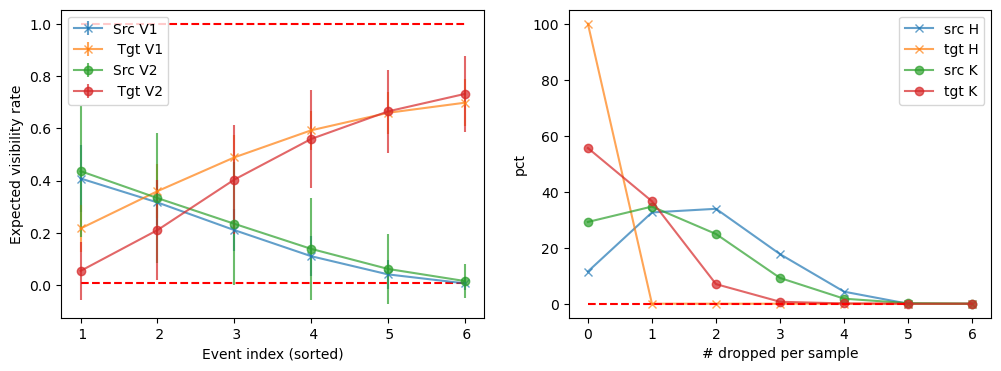

In [20]:
mm = MultinomialMasking(world, 
                        objective=ObjectiveConfig(c1_prior= 1/T, c0_prior= 1,    
                                                  c1_src= 1, c0_src=4, c1_tgt=4, c0_tgt=16,
                                                  event_dims=['t', 'v'], stratify=True))
print(mm.prior.c1)
srcs, tgts = [], []
misc = []
for _ in range(1000):
    src, tgt, _, _ = mm((1,))
    sm = torch.unravel_index(src, world.token_shape)[event_id].squeeze().bincount(minlength=T) / N
    tm = torch.unravel_index(tgt, world.token_shape)[event_id].squeeze().bincount(minlength=T) / N
    srcs.append(sm)
    tgts.append(tm)
    #misc.append(md4.squeeze())

srcs = torch.stack(srcs)
tgts = torch.stack(tgts)
#misc = torch.stack(misc)

rsrc_mm = srcs.sort(dim=1, descending=True).values
rtgt_mm = tgts.sort(dim=1, descending=False).values

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.errorbar(x = torch.arange(T), y = rsrc_hm.mean(dim=0), yerr=rsrc_hm.std(dim=0), fmt='x-', label='Src V1', alpha=0.7)
plt.errorbar(x = torch.arange(T), y = rtgt_hm.mean(dim=0), yerr=rtgt_hm.std(dim=0), fmt='x-', label=' Tgt V1', alpha=0.7)
plt.hlines(0.01, 0, T - 1, colors='red', linestyles='dashed')

plt.errorbar(x = torch.arange(T), y = rsrc_mm.mean(dim=0), yerr=rsrc_mm.std(dim=0), fmt='o-', label='Src V2', alpha=0.7)
plt.errorbar(x = torch.arange(T), y = rtgt_mm.mean(dim=0), yerr=rtgt_mm.std(dim=0), fmt='o-', label=' Tgt V2', alpha=0.7)

plt.ylabel('Expected visibility rate')
plt.xticks(ticks= torch.arange(T), labels= [f' {i+1}' for i in range(T)])
plt.xlabel('Event index (sorted)')
plt.legend()
plt.hlines(1, 0, T - 1, colors='red', linestyles='dashed')

plt.subplot(122)
plt.plot((rsrc_hm == 0).sum(1).bincount(minlength=T + 1) / 10, 'x-',alpha = 0.7, label = 'src H')
plt.plot((rtgt_hm == 0).sum(1).bincount(minlength=T + 1) / 10, 'x-',alpha = 0.7, label = 'tgt H')
plt.plot((rsrc_mm == 0).sum(1).bincount(minlength=T + 1) / 10, 'o-',alpha = 0.7, label = 'src K')
plt.plot((rtgt_mm == 0).sum(1).bincount(minlength=T + 1) / 10, 'o-',alpha = 0.7, label = 'tgt K')
plt.legend()
plt.xlabel('# dropped per sample')
plt.hlines(0.01, 0, T - 1, colors='red', linestyles='dashed')
plt.ylabel('pct')

In [9]:
#plt.errorbar(x = torch.arange(misc.size(1)), y = misc.mean(0), yerr=misc.std(0))

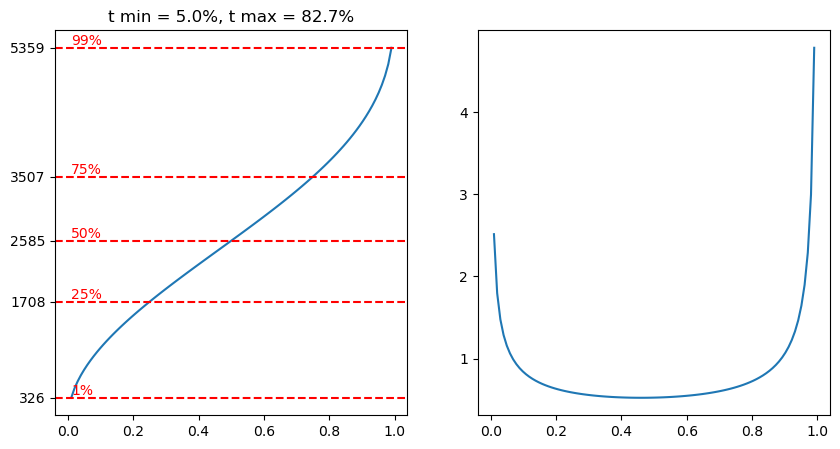

In [38]:
eps = 1e-2
u = torch.linspace(eps, 1 - eps,101)
c1 = 2
c0 = 4

k_min = 1
k_max = world.num_tokens
km = StableKumaraswamy(c1=c1, c0=c0)
t = km.quantile(u)
t = k_min + (k_max - k_min) * t
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(u, t)
plt.title(f"t min = {100*t.min().item()/k_max:.1f}%, t max = {100*t.max().item()/k_max:.1f}%")
# add quantile lines
qtls = [u.min().item(), 0.25, 0.5, 0.75, u.max().item()]
for q in qtls:
    uq = torch.tensor(q).unsqueeze(0)
    tq = km.quantile(uq)
    tq = k_min + (k_max - k_min) * tq
    plt.axhline(tq.item(), color='red', linestyle='--')
    plt.text(0.01, tq.item(), f"{q*100:.0f}%", color='red', va='bottom')
# add tick marks on y axis at quantiles
plt.yticks([k_min + (k_max - k_min) * km.quantile(torch.tensor(q).unsqueeze(0)).item() for q in qtls])
plt.subplot(1,2,2)
plt.plot(u, km.quantile_dt(u))


Text(0, 0.5, 'masking rate')

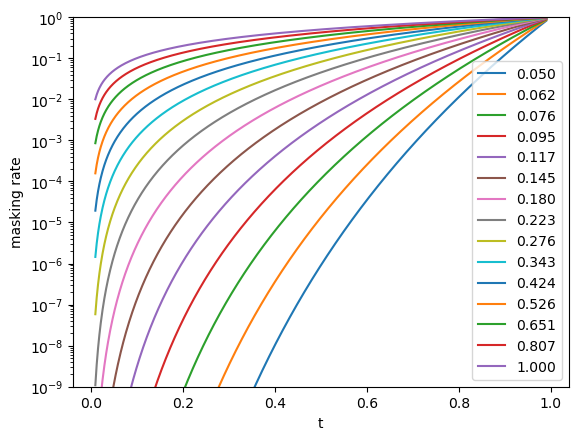

In [11]:
u = torch.linspace(1e-2,1 - 1e-2,1000)
for c1 in torch.linspace(-3, 0, 15).exp():
    km = StableKumaraswamy(c1=c1, c0=1)
    plt.plot(u, km.quantile(u), label = f'{c1:.3f}')

plt.yscale('log')
plt.legend()
plt.ylim(1e-9, 1.)
plt.xlabel('t')
plt.ylabel('masking rate')

In [12]:
0.18
0.09

0.223

0.117

0.117

Text(0, 0.5, 'masking rate')

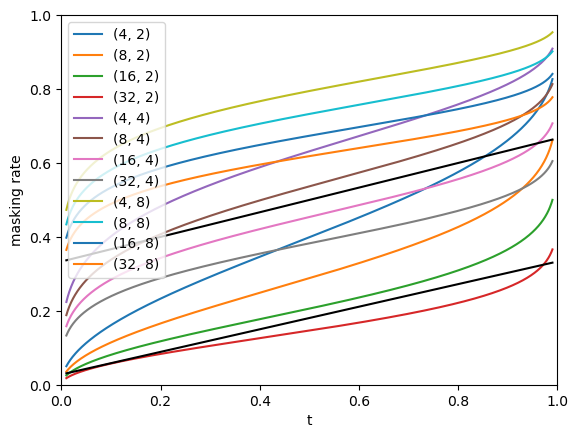

In [31]:
u = torch.linspace(1e-2,1 - 1e-2,1000)
a1 = [2, 4, 8]
a0 = [4, 8, 16, 32]
for c1, c0 in itertools.product(a1, a0):
    km = StableKumaraswamy(c1=c1, c0=c0)
    plt.plot(u, km.quantile(u), label = f'{c0, c1}')

r_tgt = 768/2304 + (1536/2304 - 768/2304) * u
r_src = 64/2304 + (768/2304 - 64/2304) * u
plt.plot(u, r_tgt, c = "black")
plt.plot(u, r_src, c = "black")
plt.ylim(0,1)
plt.xlim(0,1)
plt.legend()
plt.xlabel('t')
plt.ylabel('masking rate')

In [14]:
1 / (world.token_sizes['t'] * 1 * 2.5)

0.03333333333333333